<a href="https://colab.research.google.com/github/code2themoon/bio/blob/main/Aakriti_PneumoniaDetection_Section3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we'll try out our model on field data - data outside our normal testing and training data! We'll also learn techniques for data augmentation, creating new "fake data" so that our model can generalize more effectively.

In this notebook we'll be:
1.   Putting our ML models into practice
2.   Improving our ML models



In [ ]:
#@title Setup & Data Preparation Cell { display-mode: "form" }

# -------------------------- #
# INSTALLATION
# -------------------------- #
!pip install -q albumentations

# -------------------------- #
# IMPORTS
# -------------------------- #
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import (Activation, MaxPooling2D, Dropout, Flatten, Reshape,
                          Dense, Conv2D, GlobalAveragePooling2D, Input)
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.applications import VGG16, VGG19, DenseNet121
from tensorflow.keras.applications import ResNet50

import albumentations as A

# -------------------------- #
# AUGMENTATION FUNCTIONS
# -------------------------- #
def apply_aug(data, transform):
    if len(data.shape) == 3:
        return transform(image=data)['image']
    return np.stack([transform(image=img)['image'] for img in data])

def rotate(data, angle):
    return apply_aug(data, A.Rotate(limit=angle, p=1))

def shear(data, shear_val):
    return apply_aug(data, A.Affine(shear={"x": shear_val, "y": 0}, p=1))

def scale(data, scale_val):
    return apply_aug(data, A.Affine(scale=scale_val, p=1))

def flip_left_right(data, prob): return apply_aug(data, A.HorizontalFlip(p=prob))
def flip_up_down(data, prob): return apply_aug(data, A.VerticalFlip(p=prob))

def remove_color(data, channel):
    new_data = data.copy()
    if len(data.shape) == 3:
        new_data[:, :, channel] = 0
    elif len(data.shape) == 4:
        new_data[:, :, :, channel] = 0
    return new_data

# -------------------------- #
# DATA LOADING & PROCESSING
# -------------------------- #
class pkg:
    @staticmethod
    def get_metadata(metadata_path, splits=['train', 'test']):
        return pd.read_csv(metadata_path).query("split in @splits")

    @staticmethod
    def get_data_split(split_name, flatten, all_data, metadata, shape):
        df = metadata[metadata['split'] == split_name]
        data = all_data[df['index'].values]
        labels = df['class'].values
        return data.reshape([-1, np.prod(shape)]) if flatten else data, labels

    @staticmethod
    def get_field_data(flatten, all_data, metadata, shape):
        data, labels = pkg.get_data_split('field', flatten, all_data, metadata, shape)
        data[:, :, :, 1] = data[:, :, :, 0]
        data[:, :, :, 2] = data[:, :, :, 0]
        rand = random.uniform(-1, 1)
        for i in range(len(data)):
            data[i] = rotate(data[i], rand * 40) if abs(rand) < 0.5 else shear(data[i], rand * 40)
        return data, labels

# -------------------------- #
# HELPER FUNCTIONS
# -------------------------- #
class helpers:
    @staticmethod
    def plot_one_image(data, labels=[], index=None, shape=[64, 64, 3]):
        if data.ndim == 1:
            data = data.reshape(shape)
        elif data.ndim == 2:
            data = data.reshape([-1] + shape)

        img = data if data.ndim == 3 else data[index]
        label = labels if data.ndim == 3 else labels[index]
        print(f"Label: {label}")
        plt.imshow(img)
        plt.show()

    @staticmethod
    def plot_acc(history, ax=None, xlabel='Epoch #'):
        history = pd.DataFrame(history.history)
        history['epoch'] = history.index
        best_epoch = history['val_accuracy'].idxmax()

        if ax is None:
            _, ax = plt.subplots()
        sns.lineplot(data=history, x='epoch', y='accuracy', label='Training', ax=ax)
        sns.lineplot(data=history, x='epoch', y='val_accuracy', label='Validation', ax=ax)
        ax.axhline(0.5, ls='--', color='red', label='Chance')
        ax.axvline(best_epoch, ls='--', color='green', label='Best Epoch')
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Accuracy')
        ax.legend()
        plt.show()

    @staticmethod
    def combine_data(data_list, label_list):
        return np.concatenate(data_list, axis=0), np.concatenate(label_list, axis=0)

# -------------------------- #
# MODEL BUILDERS
# -------------------------- #
class models:
    @staticmethod
    def DenseClassifier(hidden_layers, params):
        model = Sequential([Input(params['input_shape']), Flatten(), Dropout(0.5)])
        for size in hidden_layers:
            model.add(Dense(size, activation='relu'))
            model.add(Dropout(0.5))
        model.add(Dense(params['output_neurons'], activation=params['output_activation']))
        model.compile(loss=params['loss'],
                      optimizer=keras.optimizers.SGD(1e-4, momentum=0.95),
                      metrics=['accuracy'])
        return model

    @staticmethod
    def CNNClassifier(n_layers, params):
        model = Sequential([Input(params['input_shape']),
                            Conv2D(32, 3, padding='same', kernel_regularizer=l2(0.01)), Activation('relu'),
                            MaxPooling2D(2)])
        for _ in range(n_layers - 1):
            model.add(Conv2D(64, 3, padding='same', kernel_regularizer=l2(0.01)))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dropout(0.5))
        model.add(Dense(params['output_neurons'], activation=params['output_activation']))
        model.compile(loss=params['loss'],
                      optimizer=keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9),
                      metrics=['accuracy'])
        return model

    @staticmethod
    def TransferClassifier(name, params, trainable=False):
        base_model = {'VGG16': VGG16, 'VGG19': VGG19,
                      'ResNet50': ResNet50, 'DenseNet121': DenseNet121}[name](
            include_top=False, weights='imagenet', input_shape=params['input_shape']
        )
        for layer in base_model.layers:
            layer.trainable = trainable
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(params['output_neurons'], activation=params['output_activation'])
        ])
        model.compile(loss=params['loss'],
                      optimizer=keras.optimizers.SGD(1e-4, momentum=0.9),
                      metrics=['accuracy'])
        return model

# -------------------------- #
# CONFIGURATION
# -------------------------- #
image_shape = (64, 64, 3)
metadata_path = './metadata.csv'
image_data_path = './image_data.npy'
metadata_url = "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
image_url = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy'

!wget -q --show-progress "$metadata_url" -O $metadata_path
!wget -q --show-progress "$image_url" -O $image_data_path

_all_data = np.load(image_data_path)
_metadata = pkg.get_metadata(metadata_path, ['train', 'test', 'field'])

# -------------------------- #
# SHORTCUTS
# -------------------------- #
get_metadata = lambda: pkg.get_metadata(metadata_path, ['train', 'test'])
get_train_data = lambda flatten=False: pkg.get_data_split('train', flatten, _all_data, _metadata, image_shape)
get_test_data = lambda flatten=False: pkg.get_data_split('test', flatten, _all_data, _metadata, image_shape)
get_field_data = lambda flatten=False: pkg.get_field_data(flatten, _all_data, _metadata, image_shape)

plot_one_image = lambda data, labels=[], index=None: helpers.plot_one_image(data, labels, index, image_shape)
plot_acc = helpers.plot_acc
combine_data = helpers.combine_data

DenseClassifier = lambda h: models.DenseClassifier(h, nn_params)
CNNClassifier = lambda n: models.CNNClassifier(n, nn_params)
TransferClassifier = lambda name: models.TransferClassifier(name, nn_params)

monitor = ModelCheckpoint('./model.keras', monitor='val_accuracy', save_best_only=True)

# -------------------------- #
# MODEL PARAMS
# -------------------------- #
nn_params = {
    'input_shape': image_shape,
    'output_neurons': 1,
    'loss': 'binary_crossentropy',
    'output_activation': 'sigmoid'
}


./metadata.csv      100%[===================>]  39.56K  --.-KB/s    in 0.04s   
./image_data.npy    100%[===================>] 131.25M  23.1MB/s    in 7.0s    


# Milestone 1: Putting our model into practice

## Activity 1a: Testing on Field Data

While your models may have done well on your original training and validation data, deploying the model on "field" data can present different challenges. Field data is data that is different from the one where you built your model (e.g., images obtained from a different x-ray machine)

### Exercise (Coding)

When we worked with CNNs in the last notebook, we noticed they performed much better than our multi-layered perceptrons on imaging data.

Below, please **re-train a 2-layer CNN and plot its accuracy over time!**

You can use all the functions from the previous notebook and choose the number of epochs.

In [ ]:
X_train, y_train = get_train_data()
X_test, y_test   = get_test_data()

### YOUR CODE HERE

cnn = CNNClassifier(2)
cnn_history = cnn.fit(X_train, y_train, epochs = 200, validation_data = (X_test, y_test), shuffle = True, callbacks = [monitor])
### END CODE

Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - accuracy: 0.5248 - loss: 1.9779 - val_accuracy: 0.7600 - val_loss: 1.7322
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6430 - loss: 1.6458 - val_accuracy: 0.8700 - val_loss: 1.2706
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8345 - loss: 1.2133 - val_accuracy: 0.8100 - val_loss: 1.0405
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8765 - loss: 0.9442 - val_accuracy: 0.7425 - val_loss: 1.0291
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9219 - loss: 0.7456 - val_accuracy: 0.6100 - val_loss: 1.6414
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9020 - loss: 0.6438 - val_accuracy: 0.7425 - val_loss: 0.9831
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9457 - loss: 0.4880 - val_accuracy: 0.7300 - val_loss: 0.9508
Epoch 8/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9461 - loss: 0.4086 - val_accuracy: 0.7450 -

### Exercise (Coding)

Our radiologist friends have provided us with some new data from the field. We can access this with `get_field_data()`.

In the code cell below, save the result of calling `get_field_data()` to `X_field` and `y_field`.

In [ ]:
### YOUR CODE HERE
X_field, y_field = get_field_data()

What accuracy do you get when you use your trained CNN on the field data? Please calculate it below!

Hint: if your predictions are saved as `pred_probabilities`, what do you think something like `pred_probabilities > 0.5` would do? Test it out!

In [ ]:
### YOUR CODE HERE
pred_probabilities = cnn.evaluate(X_test, y_test)
print(pred_probabilities[1] > 0.5)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6545 - loss: 1.7419 
True


**Discuss:** How does your performance on field data compare to test and train data?



You've probably noticed that you get different performance every time you train your model! Let's get a sense of the average: below, please **train your model 5 times, calculate the accuracy on the field data each time, and print the average accuracy.**

In [ ]:
### YOUR CODE HERE
cnn_history = cnn.fit(X_train, y_train, epochs = 5, validation_data = (X_field, y_field), shuffle = True, callbacks = [monitor])

pred_probabilities = cnn.evaluate(X_field, y_field)
### END CODE

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9913 - loss: 0.0595 - val_accuracy: 0.5625 - val_loss: 2.6492
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9913 - loss: 0.0479 - val_accuracy: 0.5975 - val_loss: 2.5031
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9983 - loss: 0.0366 - val_accuracy: 0.6050 - val_loss: 2.6228
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0346 - val_accuracy: 0.6300 - val_loss: 2.3062
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9976 - loss: 0.0367 - val_accuracy: 0.6575 - val_loss: 1.9593
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6427 - loss: 2.1299 


## Activity 1b: Understanding our model's performance on field data

### Exercise (Discussion)
Discuss this with your instructor:
* How did your model do? Did it perform quite as well?
* Why do you think it did this way?
* **Come up with a few hypotheses for what's different between our test data and our field data!**

## Activity 1c: Error analysis

### Understanding where the model did not perform as well

### Exercise (Coding)

Since our `X_field` comes from the field, it's possible that it's different from `X_train` and `X_test` in some important ways!

Let's compare a few images. Below, please use a `for` loop and `plot_one_image(data, labels, index)` to print out a few images from the different datasets.

**Do you notice any differences in the datasets?**




Label: 1.0


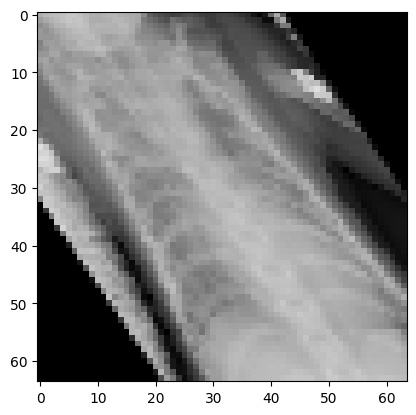

Label: 1.0


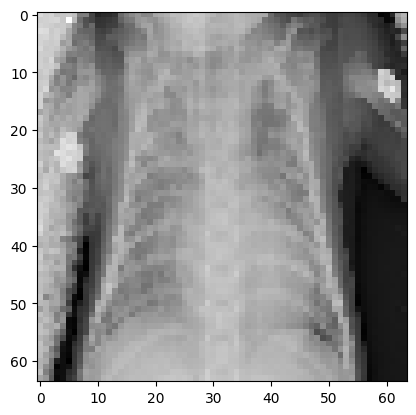

Label: 0.0


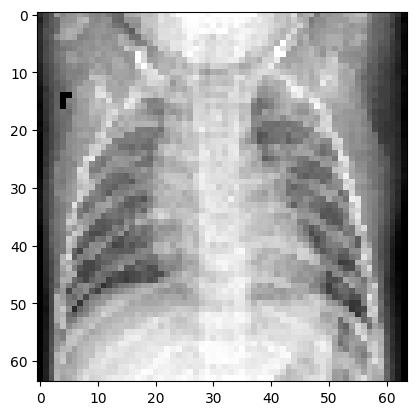

Label: 1.0


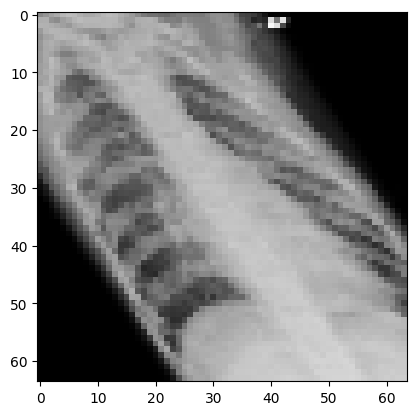

Label: 1.0


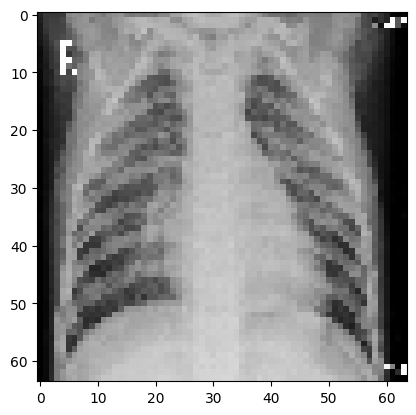

Label: 0.0


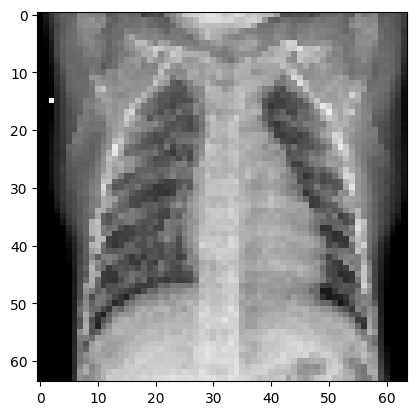

Label: 0.0


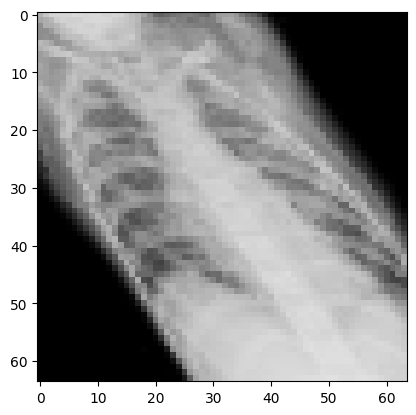

Label: 0.0


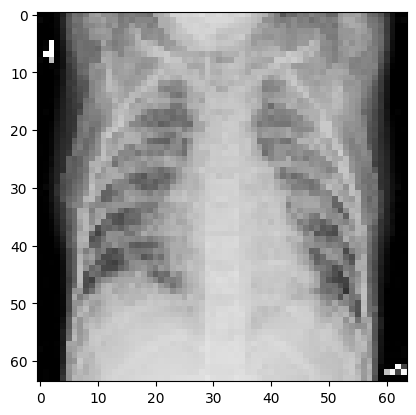

Label: 1.0


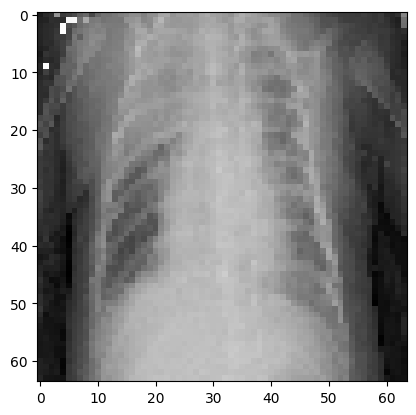

Label: 0.0


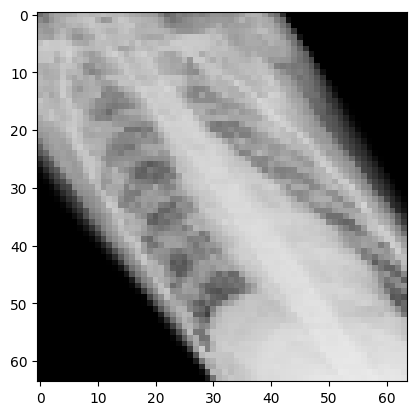

Label: 0.0


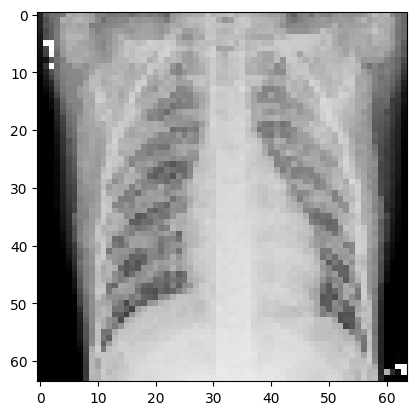

Label: 0.0


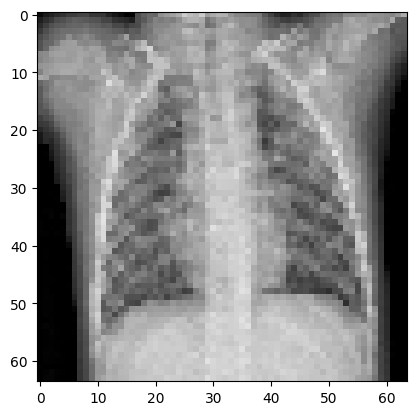

Label: 0.0


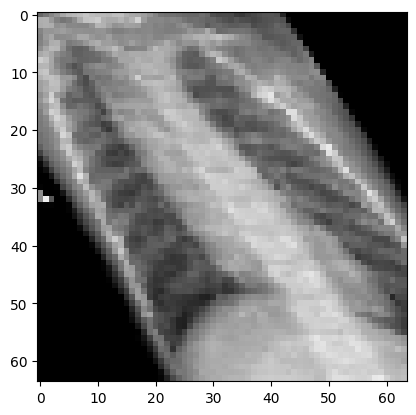

Label: 0.0


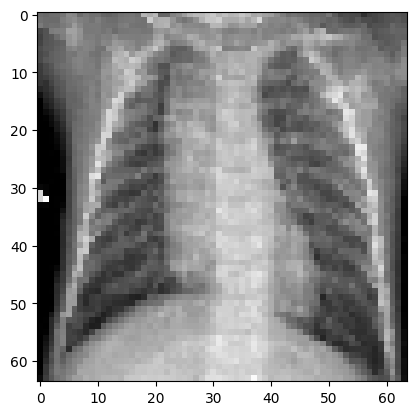

Label: 1.0


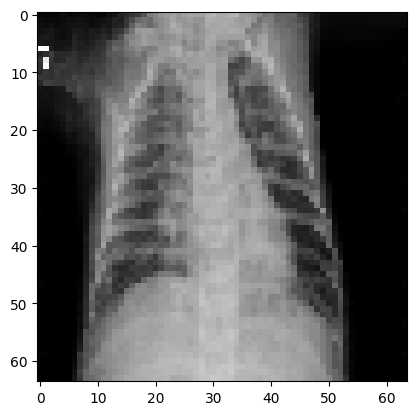

Label: 1.0


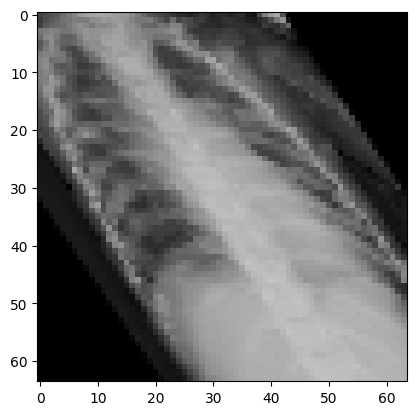

Label: 1.0


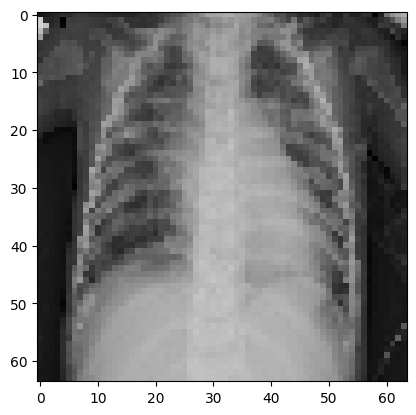

Label: 1.0


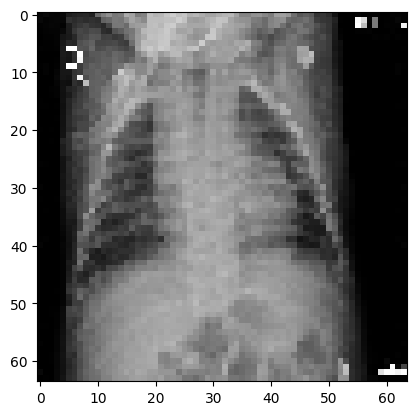

Label: 0.0


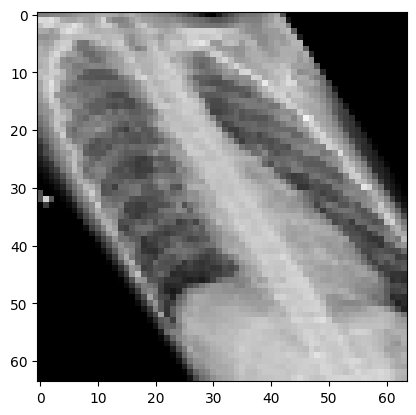

Label: 0.0


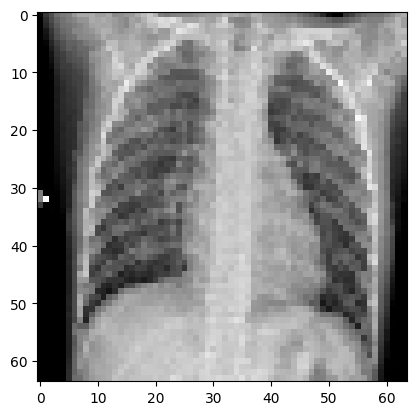

Label: 1.0


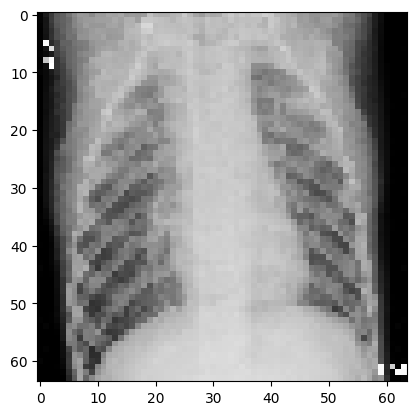

Label: 1.0


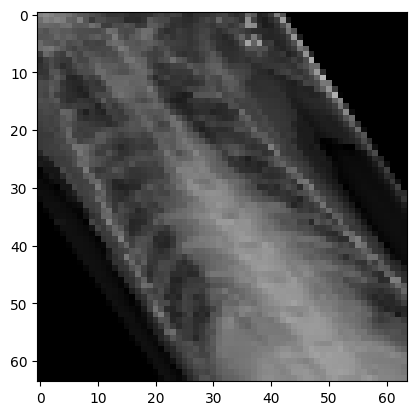

Label: 1.0


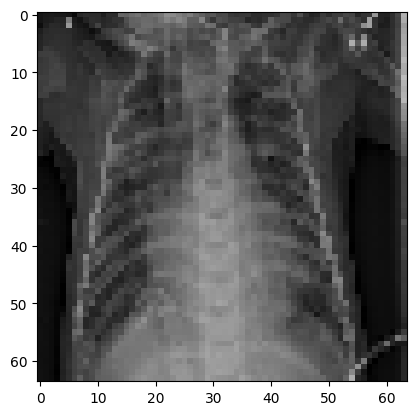

Label: 0.0


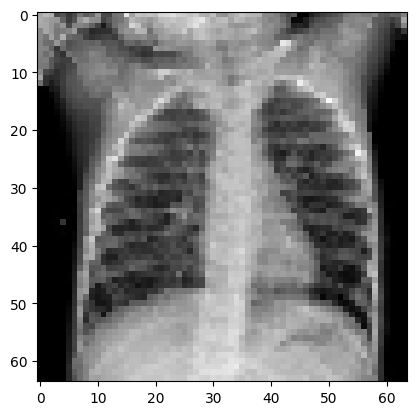

Label: 0.0


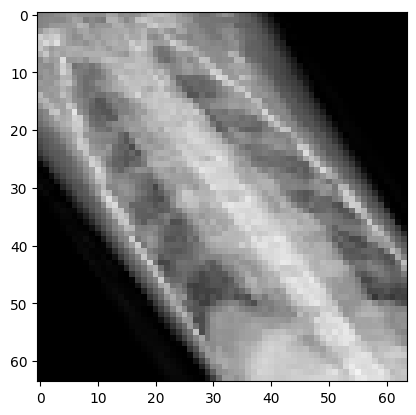

Label: 0.0


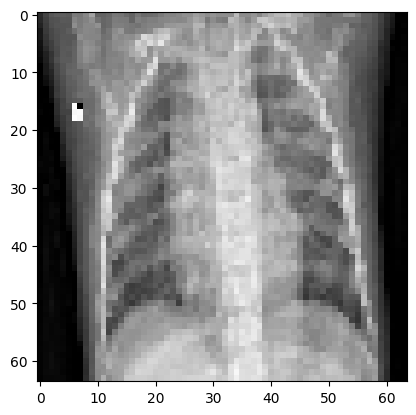

Label: 1.0


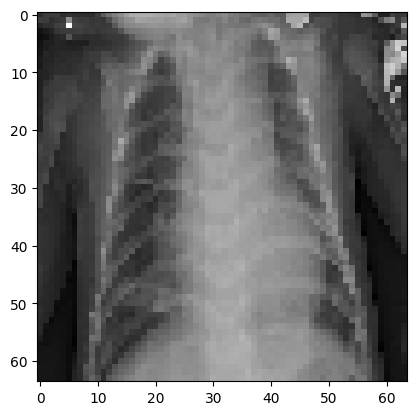

Label: 0.0


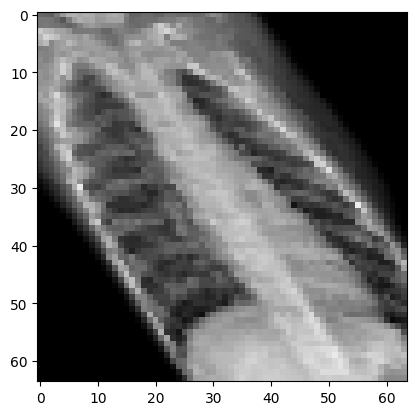

Label: 0.0


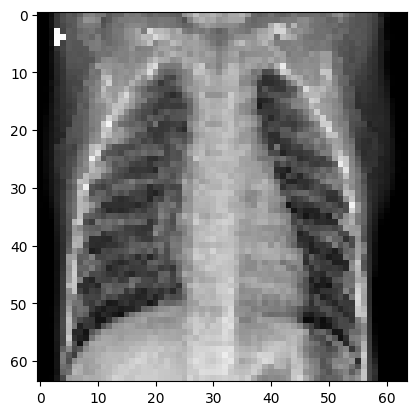

Label: 1.0


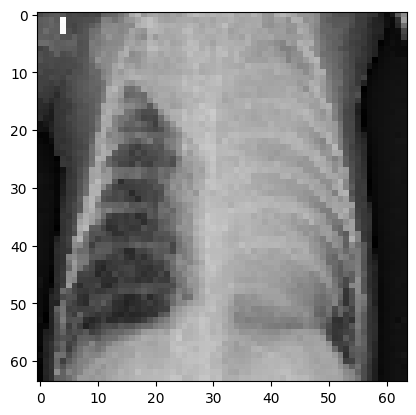

In [ ]:
### YOUR CODE HERE
for i in range (10):
  plot_one_image(X_field, y_field, i)
  plot_one_image(X_test, y_test, i)
  plot_one_image(X_train, y_train, i)
### END CODE

## Instructor-Led Discussion: What is happening in our field data?

Discuss in your group and with your instructor:

Why is our model performance suffering? What are reasons that field data could be "messier"?

# Milestone 2: Tools to improve your models

## Activity 2a

### Instructor-Led Discussion: Data Augmentation

We want our model to handle a broader variety of input data. One way to do this is to **augment** our data: by intentionally making some alterations to our input data, we can train our model to handle a greater variety of outputs.

### Exercise (Coding)

So, how do we augment our images in Python?


We provide custom functions for augmenting a single image. Here's one example, to rotate a single image by 40 degrees. **Experiment with changing the degrees! How can you rotate left?**

Label: []


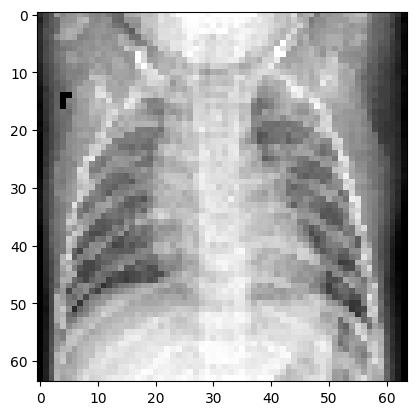

Label: []


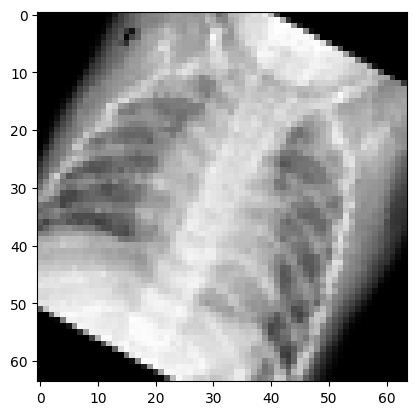

In [ ]:
image = X_train[0]
plot_one_image(image)
new_image = rotate(image, 40)
plot_one_image(new_image)


Here's some more image transformation options:
* `rotate(image, 30)`
* `scale(image, 1.5)`
* `shear(image, 20)`
* `flip_left_right(image, prob = 0.5)`
* `flip_up_down(image, prob = 0.5)`
* `remove_color(image, channel = 0)`

Try it out below!

Label: []


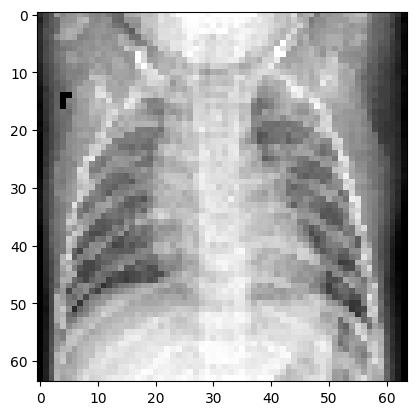

Label: []


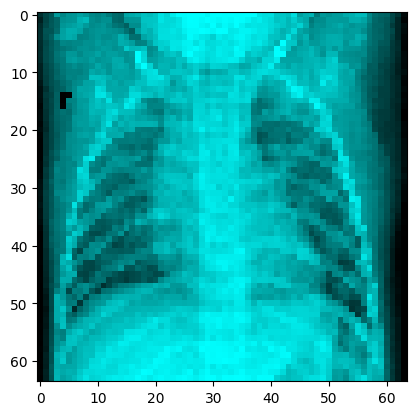

In [ ]:
### YOUR CODE HERE
image = X_train[0]
plot_one_image(image)
new_image = remove_color(image, channel = 0)
plot_one_image(new_image)

Now, experiment with these options!

**Share some of your cool augmentation strategies with the class! You can definitely use multiple augmentation techniques for each image!**

In [ ]:
### YOUR CODE HERE

### END CODE

## Activity 2b.

### Exercise (Coding)

Now, let's create some augmented datasets of our own! We'll combine the augmented data with the original. Here's how you make an augmented dataset with a custom function we've defined for you:

In [ ]:
train_data_rotated_10 = rotate(X_train, 10)

Please make some more augmented datasets below!

In [ ]:
### YOUR CODE HERE to create more augmented datasets
train_data_color = remove_color(X_train, channel = 0)
train_data_shear = shear(X_train, 20)
train_data_left_right = flip_left_right(X_train, prob = 0.5)





Finally, to combine your original train data with your augmented data, you can use the `combine_data` function like this:
```
all_data, all_labels = combine_data([data1, data2], [labels1, labels2])
```

(You can include as many datasets as you like in the list. What should you use for the new labels?)

Please create `all_data` and `all_labels` below:

In [ ]:
### YOUR CODE HERE
all_data, all_labels = combine_data([train_data_shear, train_data_color, train_data_left_right, X_train], [y_train, y_train, y_train, y_train])
### END CODE

Once you've created your augmented data...
1. Train your CNN on `all_data`
2. Choose the best epoch based on the `X_test`
3. Load your model up and score it on `X_field`

**Your challenge is to find a set of augmentations that improves your model's performance on the `X_field`! Share your augmentations and performances with the class! Try as many or as few augmentations as you want.**

**Remember to record an average of 5 newly initialized CNNs. This is important because CNN weights will be initialized differently in each run!**

In [ ]:
X_train, y_train = get_train_data()
X_test, y_test   = get_test_data()
X_field, y_field   = get_field_data()

### YOUR CODE HERE

cnn_history = cnn.fit(all_data, all_labels, epochs = 5, validation_data = (X_field, y_field), shuffle = True, callbacks = [monitor])

pred_probabilities = cnn.evaluate(X_field, y_field)

from sklearn.metrics import accuracy_score, confusion_matrix
confusion = confusion_matrix(y_test, y_field)

sns.heatmap(confusion, annot = True, fmt = 'd', cbar_kws={'label':'count'});
plt.ylabel('Actual');
plt.xlabel('Predicted');
### END CODE

NameError: name 'get_train_data' is not defined

**Discussion Question**: Why does data augmentation improve average performance?

## Saving Your Model for a Web App

Now that you've finished up with training your models on augmented data, you can use the cell below to save the model for use with a web app in the next notebook!

This cell saves whatever is in the `cnn` variable, so if your model is in a different variable, change `cnn.save(file_name)` to `YOUR_MODEL.save(file_name)` in the code cell!


In [ ]:
#@title Run this cell to download your model to use in the next notebook's app deployment!
import shutil
from google.colab import drive, files

#@markdown > You're free to change the name of the saved file below; just make sure it ends in `.keras`!
#@markdown - If you're saving multiple different models, you'll definitely want to change the file name between saves. Make sure the name is descriptive so you remember which file is which!
file_name = "cnn_model_pneumonia_detection.keras" #@param {"type":"string"}
cnn.save(file_name)

#@markdown ---
#@markdown > If you want the file saved to your Google Drive, keep the box checked! Once you run the cell, it will ask for access. If you don't have enough space, you can uncheck the box to download the file to your computer.
download_to_Google_Drive = False  # @param {"type":"boolean"}

# Copy to Google Drive or download it
if download_to_Google_Drive:
    drive.mount('/content/drive')
    shutil.copy(file_name, '/content/drive/My Drive/')
else:
    files.download(file_name)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Congratulations on completing your model!

By augmenting your data, you've (hopefully) gotten your models working better, even on messy field data!

As a further challenge, you can return to any point in the challenge and try to improve:
- Try looking at the CNN code in the hidden cell at the top. Can you change the parameters to reduce overfitting?
- Try out different classifiers from Scikit-learn with augmented data.
- Create new combinations of augmentations for your data.
- Whatever ideas you come up with!